# NLP Project: Pokemon Type Predictor
## Author: Brady Lamson
## Date: Fall 2023

# Data Loading

Here we connect to kaggle and download the dataset. Note that an access token is required to run this code. 
This file also has some wack encoding, so I have to modify that to read in the file.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.style

In [2]:
# This part requires an api key. On linux this will be saved to your home directory in .kaggle/kaggle.json
!kaggle datasets download -d cristobalmitchell/pokedex
data_path = "./data/pokemon.csv"
if not os.path.isfile(data_path):
    !unzip pokedex.zip -d data

df = pd.read_csv(data_path, sep='\t', encoding='utf-16-le')
df.head()

pokedex.zip: Skipping, found more recently modified local copy (use --force to force download)


,national_number,gen,english_name,japanese_name,primary_type,secondary_type,classification,percent_male,percent_female,height_m,...,evochain_1,evochain_2,evochain_3,evochain_4,evochain_5,evochain_6,gigantamax,mega_evolution,mega_evolution_alt,description
0,1,I,Bulbasaur,Fushigidane,grass,poison,Seed Pokémon,88.14,11.86,0.7,...,Level,Ivysaur,Level,Venusaur,NaN,NaN,NaN,NaN,NaN,There is a plant seed on its back right from t...
1,2,I,Ivysaur,Fushigisou,grass,poison,Seed Pokémon,88.14,11.86,1.0,...,Level,Ivysaur,Level,Venusaur,NaN,NaN,NaN,NaN,NaN,"When the bulb on its back grows large, it appe..."
2,3,I,Venusaur,Fushigibana,grass,poison,Seed Pokémon,88.14,11.86,2.0,...,Level,Ivysaur,Level,Venusaur,NaN,NaN,Gigantamax Venusaur,Mega Venusaur,NaN,Its plant blooms when it is absorbing solar en...
3,4,I,Charmander,Hitokage,fire,NaN,Lizard Pokémon,88.14,11.86,0.6,...,Level,Charmeleon,Level,Charizard,NaN,NaN,NaN,NaN,NaN,It has a preference for hot things. When it ra...
4,5,I,Charmeleon,Lizardo,fire,NaN,Flame Pokémon,88.14,11.86,1.1,...,Level,Charmeleon,Level,Charizard,NaN,NaN,NaN,NaN,NaN,"It has a barbaric nature. In battle, it whips ..."


# Data Exploration

I always like to take a look at what we can expect from a single row. It seems this dataset contains a TON of information.

In [3]:
df.iloc[0]

national_number                                                       1
gen                                                                   I
english_name                                                  Bulbasaur
japanese_name                                               Fushigidane
primary_type                                                      grass
secondary_type                                                   poison
classification                                             Seed Pokémon
percent_male                                                      88.14
percent_female                                                    11.86
height_m                                                            0.7
weight_kg                                                           6.9
capture_rate                                                         45
base_egg_steps                                                     5120
hp                                                              

## Removing unnecessary columns

Seems we can par this down a lot and remove a ton of the columns. We only really care about a few of them, like `english_name`, `primary_type`, `secondary_type` and `description`. 

In [4]:
columns_to_keep = ['english_name', 'primary_type', 'secondary_type', 'description']
df = (
    df
    # select the relevant columns
    .loc[:, columns_to_keep]
    # Change the type columns into categories and handle NaNs in secondary typing
    .assign(
        primary_type=lambda x: x['primary_type'].astype("category"),
        secondary_type=lambda x: x['secondary_type'].fillna("none").astype("category")
    )    
)
df.head()

,english_name,primary_type,secondary_type,description
0,Bulbasaur,grass,poison,There is a plant seed on its back right from t...
1,Ivysaur,grass,poison,"When the bulb on its back grows large, it appe..."
2,Venusaur,grass,poison,Its plant blooms when it is absorbing solar en...
3,Charmander,fire,none,It has a preference for hot things. When it ra...
4,Charmeleon,fire,none,"It has a barbaric nature. In battle, it whips ..."


## Checking Types and Frequency

In [19]:
num_types = len(df.primary_type.unique())
y_axis = np.arange(num_types)
primary_counts = (
    df
    .primary_type
    .value_counts()
    .rename("primary_counts")
)
secondary_counts = (
    df
    .secondary_type
    .value_counts()
    .rename("secondary_counts")
)
count_df = (
    pd.concat([primary_counts, secondary_counts], axis=1)
    .reset_index(names="type")
)
count_df

,type,primary_counts,secondary_counts
0,water,123.0,18
1,normal,109.0,6
2,grass,86.0,22
3,bug,75.0,9
4,fire,58.0,16
5,psychic,58.0,35
6,rock,50.0,15
7,electric,49.0,9
8,fighting,36.0,26
9,dark,36.0,25


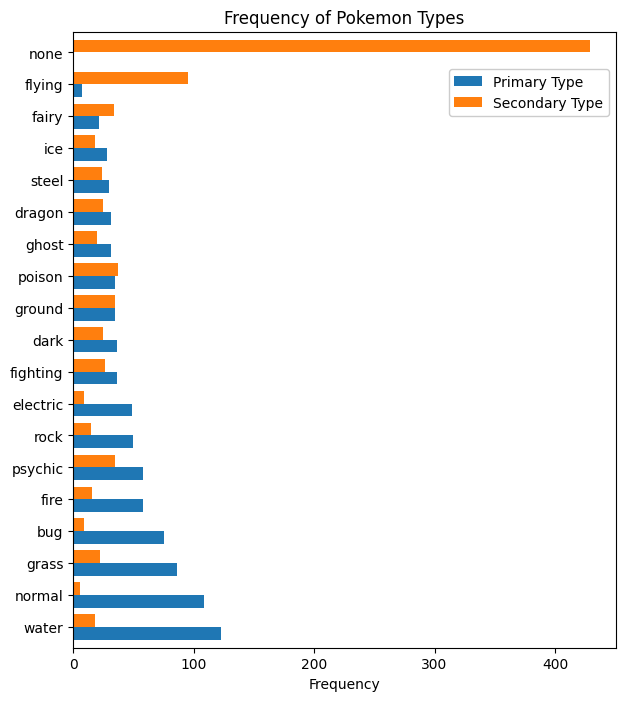

In [6]:
matplotlib.style.use("default")
ax = (
    count_df
    .plot
    .barh(
        x='type',
        figsize=(7,8),
        title="Frequency of Pokemon Types",
        xlabel="Frequency",
        ylabel="",
        # grid=True,
        width=0.8
    )
    .legend(
        ['Primary Type', 'Secondary Type'],
        loc="upper right",
        bbox_to_anchor=(1,0.95),
        fancybox=True, 
        framealpha=1,
        ncol=1
    )
)

### Thoughts

This data is very strangely unbalanced. I knew that going in but this is extreme. Some types basically only exist as primary or secondary which is super interesting. These two columns are unbalanced in almost opposite ways. This will be very interesting to work around.

## Description Length Analysis

Next up is how long are the pokemon descriptions? This is a particularly interesting question because it depends on the "generation" of games we pull this info from. Each new set of pokemon games comes with its own unique set of pokedex entries for pokemon, and they tended to get longer as the consoles they were on became more powerful. Regardless, let's see how long these are.

### Character Count Length

Text(170, 205, '$\\mu = 122.83, \\sigma = 26.23$')

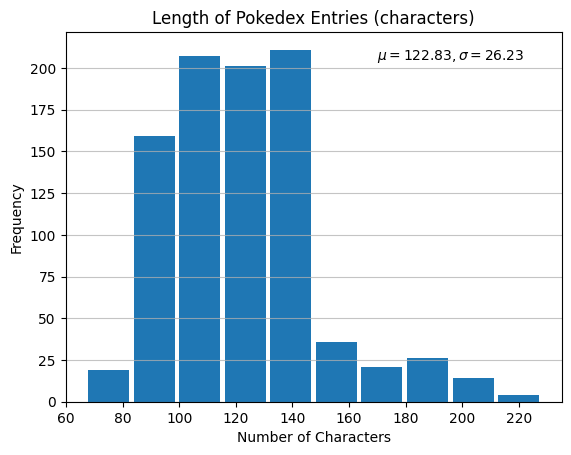

In [7]:
df = (
    df.assign(
        entry_length = df.description.apply(len)
    )
)
mean = round(df.entry_length.mean(), 2)
sd = round(df.entry_length.std(), 2)

df.entry_length.hist(rwidth=0.9, grid=False)
plt.title("Length of Pokedex Entries (characters)")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.text(170,205, f"$\mu = {mean}, \sigma = {sd}$")

Some more information

(0.0, 250.0)

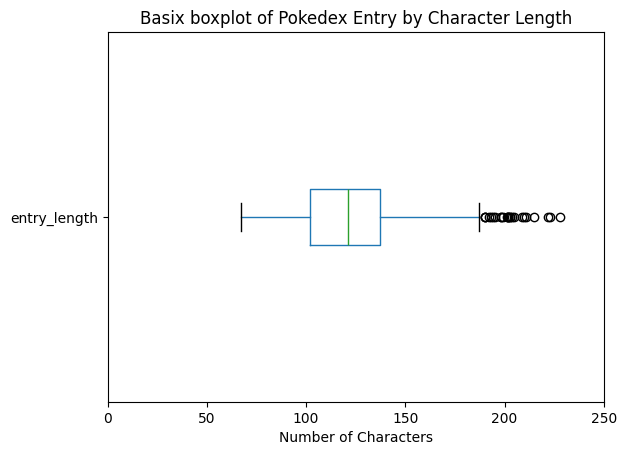

In [8]:
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
df.boxplot(column="entry_length", vert=False, grid=False)
plt.title("Basix boxplot of Pokedex Entry by Character Length")
plt.xlabel("Number of Characters")
plt.xlim(0,250)

What we can see from this is that the median pokedex description is around 120, which checks out when looking at the plot. We also have an upper quartile going up to 190 or so with a handful of outliers hanging out outside of that range.

Now, what happens if we group this data by primary or secondary types? In other words, what do the boxplots of each individual type look like?

In [9]:
# Helper function taken from: https://deparkes.co.uk/2016/11/04/sort-pandas-boxplot/

def boxplot_sorted(df, by, column, rot=0):
    # use dict comprehension to create new dataframe from the iterable groupby object
    # each group name becomes a column in the new dataframe
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    # find and sort the median values in this new dataframe
    meds = df2.median().sort_values()
    # use the columns in the dataframe, ordered sorted by median value
    # return axes so changes can be made outside the function
    return df2[meds.index].boxplot(rot=rot, return_type="axes", vert=False, grid=False)

/tmp/ipykernel_30667/1608959919.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})


Text(0.5, 0, 'Number of Characters')

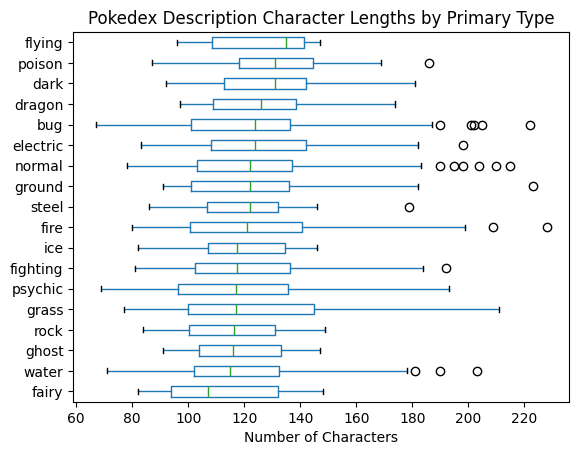

In [10]:
axes = boxplot_sorted(df, by='primary_type', column='entry_length')
plt.rcParams["figure.figsize"] = (7,8)
plt.title("Pokedex Description Character Lengths by Primary Type")
plt.ylabel("")
plt.xlabel("Number of Characters")

What we can see here is that on "average" (median) flying has the longest descriptions by character length and fairy has the shortest. Grass is super all over the place as is bug. I'm not sure if any of this will be relevant, but here we are. 

Next, same plot but grouped by secondary type.

/tmp/ipykernel_30667/1608959919.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})


Text(0.5, 0, 'Number of Characters')

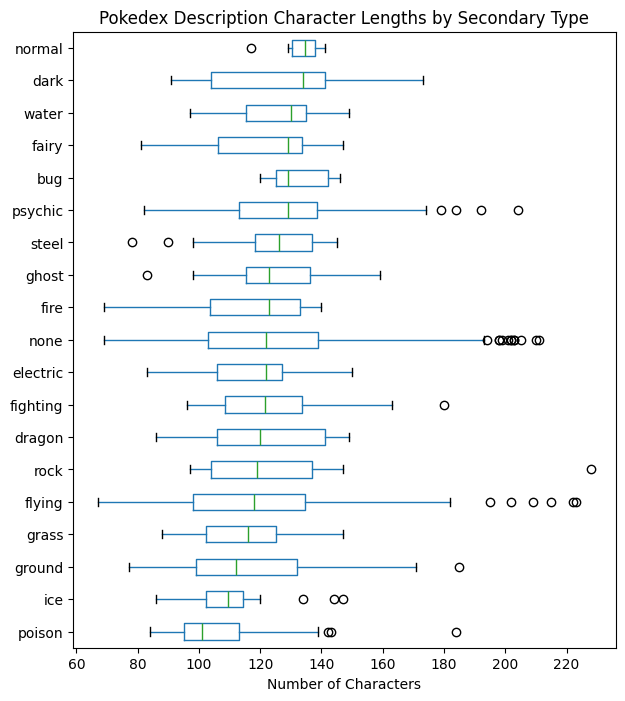

In [11]:
axes = boxplot_sorted(df, by='secondary_type', column='entry_length')
plt.rcParams["figure.figsize"] = (7,8)
plt.title("Pokedex Description Character Lengths by Secondary Type")
plt.ylabel("")
plt.xlabel("Number of Characters")

This plot is in a totally different order which isn't too surprising considering the totally different frequency of primary/secondary types. We basically have two entirely different distributions here. 

In [12]:
df.head()

,english_name,primary_type,secondary_type,description,entry_length
0,Bulbasaur,grass,poison,There is a plant seed on its back right from t...,104
1,Ivysaur,grass,poison,"When the bulb on its back grows large, it appe...",96
2,Venusaur,grass,poison,Its plant blooms when it is absorbing solar en...,90
3,Charmander,fire,none,It has a preference for hot things. When it ra...,99
4,Charmeleon,fire,none,"It has a barbaric nature. In battle, it whips ...",102


Much like the plot hints, this data is mostly gathered around the 100-140 character length range. That's good to know.

### Token Count

Text(30, 275, '$\\mu = 21.77, \\sigma = 4.79$')

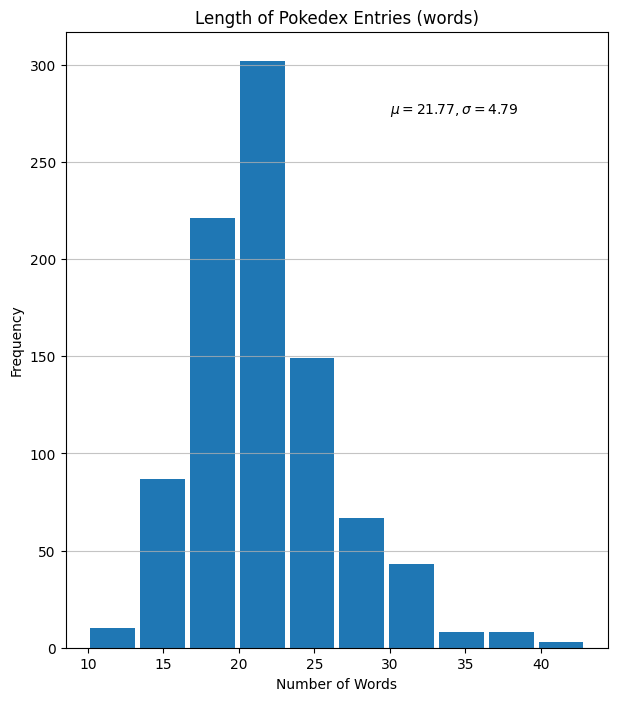

In [13]:
df = (
    df.
    assign(
        word_count=df['description'].str.split().apply(len)
    )
)

mean = round(df.word_count.mean(), 2)
sd = round(df.word_count.std(), 2)

df.word_count.hist(rwidth=0.9, grid=False)
plt.title("Length of Pokedex Entries (words)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.text(30,275, f"$\mu = {mean}, \sigma = {sd}$")

What we see is a close to normal or log-normal distribution of word length. That's neat. Not too sure if that's important, but it is cool! 

Next up, same boxplots as last time but for word length!

(0.0, 50.0)

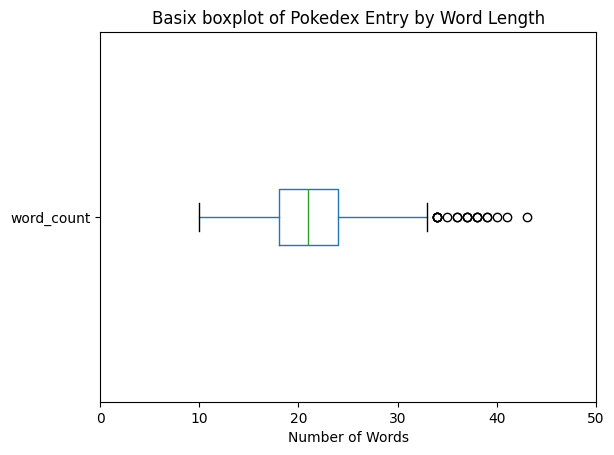

In [14]:
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
df.boxplot(column="word_count", vert=False, grid=False)
plt.title("Basix boxplot of Pokedex Entry by Word Length")
plt.xlabel("Number of Words")
plt.xlim(0,50)

/tmp/ipykernel_30667/1608959919.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})


Text(0.5, 0, 'Number of Words')

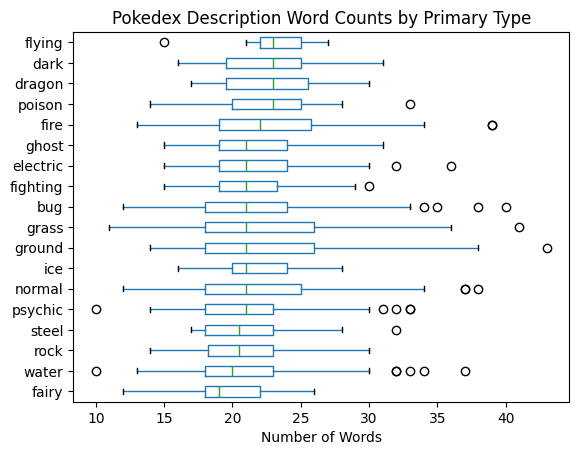

In [15]:
axes = boxplot_sorted(df, by='primary_type', column='word_count')
plt.rcParams["figure.figsize"] = (7,8)
plt.title("Pokedex Description Word Counts by Primary Type")
plt.ylabel("")
plt.xlabel("Number of Words")

/tmp/ipykernel_30667/1608959919.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})


Text(0.5, 0, 'Number of Words')

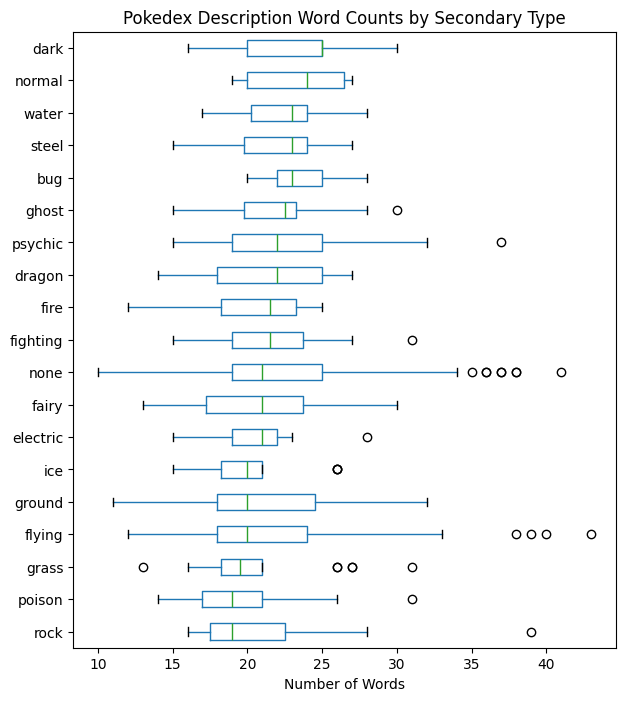

In [16]:
axes = boxplot_sorted(df, by='secondary_type', column='word_count')
plt.rcParams["figure.figsize"] = (7,8)
plt.title("Pokedex Description Word Counts by Secondary Type")
plt.ylabel("")
plt.xlabel("Number of Words")

## Unique Word Analysis

Here we want to see which words are the most common in our dataset. This includes stopwords and such, so it isn't a perfect count.

What the below code does is splits up the descriptions by words and expands itself into a large matrix. From there we stack that matrix to get a usable format to extract word counts from.

In [17]:
word_freq = (
    df
    .description
    .str
    .split(expand=True)
    .stack()
    .value_counts()
)

print(f"Number of unique words in dataset: {len(word_freq)}\n")
display(word_freq.head(25))

Number of unique words in dataset: 5100



its        711
the        666
it         539
to         521
of         480
a          458
It         356
and        327
is         283
in         281
Pokémon    272
with       213
that       189
on         188
this       157
as         147
This       146
from       140
can        136
The        130
by         106
will       102
are        100
for         92
body        91
Name: count, dtype: int64

Yeah uh, nothing too interesting yet without stopwords removed haha. There's only 5100 unique words in all of the descriptions combined though which feels low. Wonder how few it is after stopwords are removed.